In [1]:
import re
from os import environ
from os.path import join as pj
from typing import List, Tuple, Dict, Union

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, f1_score
from tqdm.auto import tqdm as tqdm_original
from transformers import AutoConfig, AutoModel
from transformers import BertForSequenceClassification
from transformers import BertTokenizer

sns.set()


def tqdm(*args, **kwargs):
    return tqdm_original(*args, **kwargs, disable=environ.get("DISABLE_TQDM", False))


DATA_FOLDER = pj('thesis', 'NLP_Course', 'HW4', 'data')
DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 8
EPOCHS = 30
LEARNING_RATE = 5e-05

In [2]:
def read_data(filepath: str) -> List[Tuple[str, str]]:
    with open(filepath, 'r') as file_handle:
        file_data = file_handle.readlines()

    indices_sentences = list(range(0, len(file_data), 4))  # Every 4 lines new input

    sentences = list(map(lambda i: file_data[i].split('\t')[1].strip('"\n '), indices_sentences))
    labels = list(map(lambda i: file_data[i + 1].strip(), indices_sentences))
    data = list(zip(sentences, labels))

    return data


_train = read_data(pj(DATA_FOLDER, 'TRAIN_FILE.TXT'))
_test = read_data(pj(DATA_FOLDER, 'TEST_FILE_FULL.TXT'))

In [3]:
def create_label_mapper(data: List[Tuple[str, str]]) -> Dict[str, int]:
    labels = list(map(lambda e: e[1], data))

    reg = re.compile('\(e[12],e[12]\)')  # Remove (e1,e2) and (e2,e1)
    labels = list(map(lambda label: reg.sub('', label), labels))

    labels_set = sorted(list(set(labels)))
    labels_dict = {label: i for i, label in enumerate(labels_set)}

    return labels_dict


_labels_dict = create_label_mapper(data=_train)
NUM_LABELS = len(_labels_dict)

_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=NUM_LABELS).to(DEVICE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [4]:
def prepare_data(data: List[Tuple[str, str]], tokenizer: BertTokenizer, labels_dict: Dict[str, int],
                 batch_size: int) -> List[Tuple[torch.Tensor, torch.Tensor, List[int]]]:
    data_sequences = []
    # TODO - your code...

    batches = [data[idx:idx + batch_size] for idx in range(0, len(data), batch_size)]
    for batch in batches:
        reg = re.compile('<[?]?e[12]>')  # Remove <e1>, <e2>, </e1>, </e2>
        sentences = list(map(lambda x: reg.sub('', x[0]), batch))

        tokens = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
        input_ids, attn_mask = tokens['input_ids'], tokens['attention_mask']

        reg = re.compile('\(e[12],e[12]\)')  # Remove (e1,e2) and (e2,e1)
        labels = list(map(lambda x: reg.sub('', x[1]), batch))
        labels_indices = list(map(lambda label: labels_dict[label], labels))

        data_sequences.append((input_ids, attn_mask, labels_indices))

    return data_sequences


_train_sequences = prepare_data(data=_train, tokenizer=_tokenizer, labels_dict=_labels_dict, batch_size=BATCH_SIZE)
_test_sequences = prepare_data(data=_test, tokenizer=_tokenizer, labels_dict=_labels_dict, batch_size=BATCH_SIZE)

In [5]:
def get_parameters(params) -> List[nn.Parameter]:
    requires_grad_layers = ["classifier", "pooler", "encoder.layer.9", "encoder.layer.10",
                            "encoder.layer.11", "blanks_linear", "lm_linear", "cls"]
    layers = []
    for name, param in params:
        param.requires_grad = any([layer in name for layer in requires_grad_layers])
        layers.append(param)

    return layers


def train_loop(model: BertForSequenceClassification, n_epochs: int,
               train_data: List[Tuple[torch.Tensor, torch.Tensor, List[int]]],
               test_data: Union[List[Tuple[torch.Tensor, torch.Tensor, List[int]]], None],
               labels_dict: Dict[str, int], lr: float, produce_learning_graph: bool):
    # Loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(get_parameters(model.named_parameters()), lr=lr)
    model.train()

    get_f1 = lambda: evaluate(model=model, test_data=test_data, labels_dict=labels_dict,
                              print_summary=False, get_f1_score=True)
    f1_scores = [get_f1()] if produce_learning_graph else []

    for _ in tqdm(range(n_epochs), 'Epochs'):
        # TODO - your code goes here...

        for step, batch in enumerate(train_data):
            input_ids, attn_mask, labels = batch

            input_ids = input_ids.to(DEVICE)
            attn_mask = attn_mask.to(DEVICE)
            labels = torch.tensor(labels).to(DEVICE)

            model.zero_grad()
            model_output = model(input_ids, attn_mask)
            logits = model_output['logits']

            loss = criterion(logits, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # To prevent exploding gradients

            optimizer.step()

        if produce_learning_graph:
            f1_scores.append(get_f1())

    evaluate(model=model, test_data=test_data, labels_dict=_labels_dict, print_summary=True, get_f1_score=False)

    x = list(range(len(f1_scores)))
    sns.lineplot(x=x, y=f1_scores)

    plt.suptitle('Epoch vs. F1 Score', fontsize=20, color='salmon')
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('F1 Score', fontsize=16)

    plt.show()


def evaluate(model: BertForSequenceClassification, labels_dict: Dict[str, int],
             test_data: List[Tuple[torch.Tensor, torch.Tensor, List[int]]],
             print_summary: bool, get_f1_score: bool) -> Union[float, None]:
    if not print_summary and not get_f1_score:
        return None

    model.eval()

    predictions, true_labels, = [], []
    pred_labels = []

    for batch in test_data:
        input_ids, attn_mask, labels = batch

        input_ids = input_ids.to(DEVICE)
        attn_mask = attn_mask.to(DEVICE)
        labels = np.asarray(labels)

        with torch.no_grad():
            model_output = model(input_ids, attn_mask)
            logits = model_output['logits'].detach().cpu().numpy()

            true_labels.append(labels)
            predictions.append(logits)

    for i in range(len(true_labels)):
        pred_labels.append(np.argmax(predictions[i], axis=1))

    true_labels = np.concatenate(true_labels).ravel().tolist()
    pred_labels = np.concatenate(pred_labels).ravel().tolist()

    idx_to_labels = {value: key for key, value in labels_dict.items()}
    y_true = list(map(lambda x: idx_to_labels[x], true_labels))
    y_pred = list(map(lambda x: idx_to_labels[x], pred_labels))

    if print_summary:
        print(classification_report(y_true=y_true, y_pred=y_pred, digits=3, zero_division=1))
    if get_f1_score:
        return f1_score(y_true=y_true, y_pred=y_pred, average='weighted')

    return None


                    precision    recall  f1-score   support

      Cause-Effect      1.000     0.000     0.000       328
   Component-Whole      1.000     0.000     0.000       312
 Content-Container      0.000     0.000     0.000       192
Entity-Destination      1.000     0.000     0.000       292
     Entity-Origin      1.000     0.000     0.000       258
 Instrument-Agency      0.057     0.974     0.108       156
 Member-Collection      0.081     0.013     0.022       233
     Message-Topic      1.000     0.000     0.000       261
             Other      1.000     0.000     0.000       454
  Product-Producer      1.000     0.000     0.000       231

          accuracy                          0.057      2717
         macro avg      0.714     0.099     0.013      2717
      weighted avg      0.796     0.057     0.008      2717



Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

                    precision    recall  f1-score   support

      Cause-Effect      0.902     0.930     0.916       328
   Component-Whole      0.792     0.843     0.817       312
 Content-Container      0.897     0.865     0.881       192
Entity-Destination      0.935     0.887     0.910       292
     Entity-Origin      0.844     0.837     0.840       258
 Instrument-Agency      0.876     0.679     0.765       156
 Member-Collection      0.806     0.858     0.832       233
     Message-Topic      0.825     0.831     0.828       261
             Other      0.599     0.593     0.596       454
  Product-Producer      0.786     0.844     0.814       231

          accuracy                          0.808      2717
         macro avg      0.826     0.817     0.820      2717
      weighted avg      0.810     0.808     0.808      2717



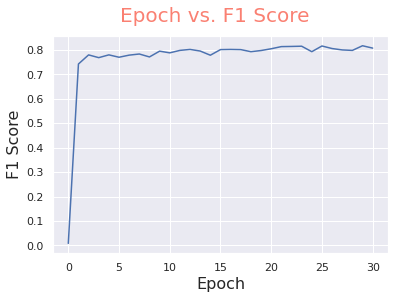

                    precision    recall  f1-score   support

      Cause-Effect      0.902     0.930     0.916       328
   Component-Whole      0.792     0.843     0.817       312
 Content-Container      0.897     0.865     0.881       192
Entity-Destination      0.935     0.887     0.910       292
     Entity-Origin      0.844     0.837     0.840       258
 Instrument-Agency      0.876     0.679     0.765       156
 Member-Collection      0.806     0.858     0.832       233
     Message-Topic      0.825     0.831     0.828       261
             Other      0.599     0.593     0.596       454
  Product-Producer      0.786     0.844     0.814       231

          accuracy                          0.808      2717
         macro avg      0.826     0.817     0.820      2717
      weighted avg      0.810     0.808     0.808      2717



In [6]:
evaluate(model=_model, test_data=_test_sequences, labels_dict=_labels_dict, print_summary=True, get_f1_score=False)

train_loop(model=_model, n_epochs=EPOCHS, train_data=_train_sequences, test_data=_test_sequences,
           labels_dict=_labels_dict, lr=LEARNING_RATE, produce_learning_graph=True)

evaluate(model=_model, test_data=_test_sequences, labels_dict=_labels_dict, print_summary=True, get_f1_score=False)

In [7]:
_tokenizer_MTB = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
_tokenizer_MTB.add_tokens(['<e1>', '</e1>', '<e2>', '</e2>'])

4

In [8]:
def prepare_data_MTB(data: List[Tuple[str, str]], tokenizer: BertTokenizer, labels_dict: Dict[str, int],
                     batch_size: int) -> List[Tuple[torch.Tensor, torch.Tensor, List[int], torch.Tensor, torch.Tensor]]:
    data_sequences = []
    # TODO - your code...

    e1_id = tokenizer.added_tokens_encoder['<e1>']
    e2_id = tokenizer.added_tokens_encoder['<e2>']

    batches = [data[idx:idx + batch_size] for idx in range(0, len(data), batch_size)]
    for batch in batches:
        sentences = list(map(lambda x: x[0], batch))

        tokens = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt", add_special_tokens=True)
        input_ids, attn_mask = tokens['input_ids'], tokens['attention_mask']

        reg = re.compile('\(e[12],e[12]\)')  # Remove (e1,e2) and (e2,e1)
        labels = list(map(lambda x: reg.sub('', x[1]), batch))

        labels_indices = list(map(lambda label: labels_dict[label], labels))

        # noinspection PyUnresolvedReferences
        e1 = (input_ids == e1_id).nonzero()[:, 1]
        # noinspection PyUnresolvedReferences
        e2 = (input_ids == e2_id).nonzero()[:, 1]

        data_sequences.append((input_ids, attn_mask, labels_indices, e1, e2))

    return data_sequences

In [9]:
_train_sequences_MTB = prepare_data_MTB(data=_train, tokenizer=_tokenizer_MTB,
                                        labels_dict=_labels_dict, batch_size=BATCH_SIZE)
_test_sequences_MTB = prepare_data_MTB(data=_test, tokenizer=_tokenizer_MTB,
                                       labels_dict=_labels_dict, batch_size=BATCH_SIZE)

In [10]:
class MTB(nn.Module):

    def __init__(self, base_model_name: str, num_labels: int, tokenizer_length: int):
        super().__init__()

        config = AutoConfig.from_pretrained(pretrained_model_name_or_path=base_model_name)
        config.num_labels = num_labels

        self.bert = AutoModel.from_pretrained(pretrained_model_name_or_path=base_model_name, config=config)
        self.bert.resize_token_embeddings(tokenizer_length)

        self.num_labels = config.num_labels
        self.hidden_size = config.hidden_size

        self.classifier = nn.Linear(in_features=self.hidden_size * 2, out_features=self.num_labels)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor, index: torch.Tensor) -> torch.Tensor:
        e1_indices = index[0].unsqueeze(-1)
        e1_indices = e1_indices.repeat(1, self.hidden_size).unsqueeze(1)

        e2_indices = index[1].unsqueeze(-1)
        e2_indices = e2_indices.repeat(1, self.hidden_size).unsqueeze(1)

        outputs = self.bert(input_ids, attention_mask=attention_mask, output_hidden_states=True)

        hidden_states_last = outputs.hidden_states[12]

        e1_hidden_states = torch.gather(hidden_states_last, 1, e1_indices)
        e2_hidden_states = torch.gather(hidden_states_last, 1, e2_indices)

        e1_hidden_states = torch.squeeze(e1_hidden_states, dim=1)
        e2_hidden_states = torch.squeeze(e2_hidden_states, dim=1)

        e1_e2_hidden_states = torch.cat((e1_hidden_states, e2_hidden_states), dim=1)

        output = self.classifier(e1_e2_hidden_states)

        return output


def train_loop_MTB(model: BertForSequenceClassification, n_epochs: int,
                   train_data: List[Tuple[torch.Tensor, torch.Tensor, List[int]]],
                   test_data: Union[List[Tuple[torch.Tensor, torch.Tensor, List[int]]], None],
                   labels_dict: Dict[str, int], lr: float, produce_learning_graph: bool):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(get_parameters(model.named_parameters()), lr=lr)

    model.train()

    get_f1 = lambda: evaluate_MTB(model=model, test_data=test_data, labels_dict=labels_dict,
                                  print_summary=False, get_f1_score=True)
    f1_scores = [get_f1()] if produce_learning_graph else []

    for _ in tqdm(range(n_epochs), 'Epochs'):
        for step, batch in enumerate(train_data):
            input_ids, attn_mask, labels, e1, e2 = batch

            input_ids = input_ids.to(DEVICE)
            attn_mask = attn_mask.to(DEVICE)
            labels = torch.tensor(labels).to(DEVICE)
            e1 = e1.to(DEVICE)
            e2 = e2.to(DEVICE)

            model.zero_grad()

            logits = model(input_ids, attn_mask, (e1, e2))

            loss = criterion(logits, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # To prevent exploding gradients

            optimizer.step()

        if produce_learning_graph:
            f1_scores.append(get_f1())

    evaluate_MTB(model=model, test_data=test_data, labels_dict=_labels_dict, print_summary=True, get_f1_score=False)

    x = list(range(len(f1_scores)))
    sns.lineplot(x=x, y=f1_scores)

    plt.suptitle('Epoch vs. F1 Score', fontsize=20, color='salmon')
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('F1 Score', fontsize=16)

    plt.show()


def evaluate_MTB(model: BertForSequenceClassification, labels_dict: Dict[str, int],
                 test_data: List[Tuple[torch.Tensor, torch.Tensor, List[int]]],
                 print_summary: bool, get_f1_score: bool) -> Union[float, None]:
    if not print_summary and not get_f1_score:
        return None

    model.eval()

    predictions, true_labels, = [], []
    pred_labels = []

    for batch in test_data:
        input_ids, attn_mask, labels, e1, e2 = batch
        input_ids = input_ids.to(DEVICE)
        attn_mask = attn_mask.to(DEVICE)
        labels = np.asarray(labels)
        e1 = e1.to(DEVICE)
        e2 = e2.to(DEVICE)

        with torch.no_grad():
            logits = model(input_ids, attn_mask, (e1, e2))
            logits = torch.log_softmax(logits, dim=1).detach().cpu().numpy()

            predictions.append(logits)
            true_labels.append(labels)

    for i in range(len(true_labels)):
        pred_labels.append(np.argmax(predictions[i], axis=1))

    pred_labels = np.concatenate(pred_labels).ravel().tolist()
    true_labels = np.concatenate(true_labels).ravel().tolist()

    idx_to_labels = {value: key for key, value in labels_dict.items()}
    y_true = list(map(lambda x: idx_to_labels[x], true_labels))
    y_pred = list(map(lambda x: idx_to_labels[x], pred_labels))

    if print_summary:
        print(classification_report(y_true=y_true, y_pred=y_pred, digits=3, zero_division=1))
    if get_f1_score:
        return f1_score(y_true=y_true, y_pred=y_pred, average='weighted')

    return None

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


                    precision    recall  f1-score   support

      Cause-Effect      0.032     0.006     0.010       328
   Component-Whole      0.082     0.131     0.101       312
 Content-Container      0.000     0.000     0.000       192
Entity-Destination      0.046     0.041     0.043       292
     Entity-Origin      0.118     0.070     0.088       258
 Instrument-Agency      0.037     0.077     0.050       156
 Member-Collection      0.023     0.004     0.007       233
     Message-Topic      0.103     0.138     0.118       261
             Other      0.267     0.009     0.017       454
  Product-Producer      0.067     0.238     0.105       231

          accuracy                          0.067      2717
         macro avg      0.078     0.071     0.054      2717
      weighted avg      0.094     0.067     0.052      2717



Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

                    precision    recall  f1-score   support

      Cause-Effect      0.883     0.918     0.900       328
   Component-Whole      0.826     0.837     0.831       312
 Content-Container      0.885     0.839     0.861       192
Entity-Destination      0.898     0.904     0.901       292
     Entity-Origin      0.826     0.810     0.818       258
 Instrument-Agency      0.898     0.679     0.774       156
 Member-Collection      0.750     0.901     0.819       233
     Message-Topic      0.828     0.923     0.873       261
             Other      0.577     0.537     0.556       454
  Product-Producer      0.863     0.818     0.840       231

          accuracy                          0.805      2717
         macro avg      0.823     0.817     0.817      2717
      weighted avg      0.804     0.805     0.802      2717



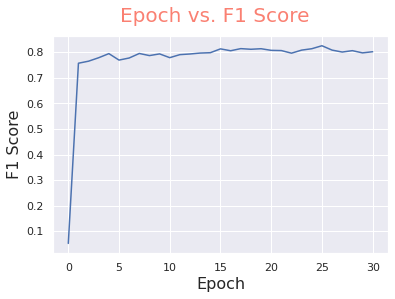

                    precision    recall  f1-score   support

      Cause-Effect      0.883     0.918     0.900       328
   Component-Whole      0.826     0.837     0.831       312
 Content-Container      0.885     0.839     0.861       192
Entity-Destination      0.898     0.904     0.901       292
     Entity-Origin      0.826     0.810     0.818       258
 Instrument-Agency      0.898     0.679     0.774       156
 Member-Collection      0.750     0.901     0.819       233
     Message-Topic      0.828     0.923     0.873       261
             Other      0.577     0.537     0.556       454
  Product-Producer      0.863     0.818     0.840       231

          accuracy                          0.805      2717
         macro avg      0.823     0.817     0.817      2717
      weighted avg      0.804     0.805     0.802      2717



In [11]:
_model_MTB = MTB(base_model_name='bert-base-uncased', num_labels=NUM_LABELS,
                 tokenizer_length=len(_tokenizer_MTB)).to(DEVICE)

evaluate_MTB(model=_model_MTB, test_data=_test_sequences_MTB, labels_dict=_labels_dict,
             print_summary=True, get_f1_score=False)

train_loop_MTB(model=_model_MTB, n_epochs=EPOCHS, train_data=_train_sequences_MTB, test_data=_test_sequences_MTB,
               labels_dict=_labels_dict, lr=LEARNING_RATE, produce_learning_graph=True)

evaluate_MTB(model=_model_MTB, test_data=_test_sequences_MTB, labels_dict=_labels_dict,
             print_summary=True, get_f1_score=False)